Most Useful:
 * [Display fns](#Display-fns)
 
TOC:
- [Imports](#Imports)
- [Constants](#Constants)
- [Some Functions](#Some-Functions)
- [File commands](#File-commands)
- [Display fns](#Display-fns)
- [Data Statistics / Analysis](#Data-Statistics-/-Analysis)

---
( And [Scrap](#[-================--------SCRAP--------================-]) )
- ["Cleaning" up datasets](#"Cleaning"-up-datasets)
  - [Clean: Remove exact duplicates [hash]](#Clean:-Remove-exact-duplicates-[hash])
  - [Clean: Min Variance threshold](#Clean:-Min-Variance-threshold)


---

# Imports

In [1]:

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## Constants

In [2]:
# File system
data_root = '.' # Change me to store data elsewhere

In [6]:
num_classes = 10
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

In [4]:
## Special declarations
# num_classes = 10
np.random.seed(133)

In [15]:
# Some more specific (early) file ones

letter_train_folders = [  # train_folders
    './notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C',
    './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F',
    './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I',
    './notMNIST_large/J'
]
letter_test_folders = [  # test_folders
    './notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C',
    './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F',
    './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I',
    './notMNIST_small/J'
]

letter_train_datafiles = [  # train_datasets
     './notMNIST_large/A.pickle',
     './notMNIST_large/B.pickle',
     './notMNIST_large/C.pickle',
     './notMNIST_large/D.pickle',
     './notMNIST_large/E.pickle',
     './notMNIST_large/F.pickle',
     './notMNIST_large/G.pickle',
     './notMNIST_large/H.pickle',
     './notMNIST_large/I.pickle',
     './notMNIST_large/J.pickle'
]

letter_test_datafiles = [  # test_datasets
     './notMNIST_small/A.pickle',
     './notMNIST_small/B.pickle',
     './notMNIST_small/C.pickle',
     './notMNIST_small/D.pickle',
     './notMNIST_small/E.pickle',
     './notMNIST_small/F.pickle',
     './notMNIST_small/G.pickle',
     './notMNIST_small/H.pickle',
     './notMNIST_small/I.pickle',
     './notMNIST_small/J.pickle'
]


# Some Functions

In [23]:
def choose_random(size, one_set, one_labels):
    idx_rand = np.random.choice(one_set.shape[0], size)
    return one_set[idx_rand], one_labels[idx_rand]

def choose_random_reshape(size, one_set, one_labels):
    idx_rand = np.random.choice(one_set.shape[0], size)
    reshape_size = one_set.shape[1] * one_set.shape[2]
    selected_set = one_set[idx_rand]
    return selected_set, one_labels[idx_rand], selected_set.reshape((size, reshape_size))

def fix_shape(one_set):
    '''Fix for LogisticRegression Classfier - Flatten each 28x28 pixels to 1D array'''
    reshape_size = one_set.shape[1] * one_set.shape[2]
    return np.reshape(one_set, (one_set.shape[0], reshape_size))


In [7]:

# I don't know if this is needed there may be a np.shuffle() fn?
#   Or i might have a better one?
def randomize_shuffle(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels


# File commands

In [22]:
# Old File fns

def coerce_letter2idx(letter = None):
    if type(letter) is str and len(letter) > 1 and letter.endswith('pickle'):
        # assume it is a full data filename
        letter = letter[-8:-7]
    letter_idx = 0 if type(letter) is not int else letter
    if letter is not None:
        letter_idx = ord(letter.upper()) - ord('A')
    return letter_idx

def coerce_letter2char(letter = None):
    if type(letter) is str and len(letter) > 1 and letter.endswith('pickle'):
        # assume it is a full data filename
        return letter[-8:-7]
    letter_chr = 'A' if type(letter) is not str else letter.upper()
    if type(letter) is int:
        letter_chr = chr(ord('A') + letter)
    return letter_chr

def get_data_filename(letter = None, is_test=False):
    if type(letter) is str and len(letter) > 1 and letter.endswith('pickle'):
        # assume it is a data filename
        return letter
    target_datasets = letter_train_datafiles if not is_test else letter_test_datafiles
    data_filename = target_datasets[coerce_letter2idx(letter)]
    return data_filename


def load_letter_pickle(letter = None, verbose=True, is_test=False):
    data_filename = get_data_filename(letter, is_test)
    with open(data_filename) as f:
        if verbose: print('loading %s ...' % data_filename)
        data_loaded = pickle.load(f)
    return data_loaded


my_train_a = load_letter_pickle(letter='A', verbose=True)

loading ./notMNIST_large/A.pickle ...


In [38]:
# Save and load pickles

_sample_pickle_filename = 'tmp_notMNIST.pickle'


def save_pickle_file(filename='tmp_notMNIST.pickle', dataset_dict=None):
    
    pickle_file = os.path.join(data_root, filename)

    try:
      f = open(pickle_file, 'wb')
      save = dataset_dict
#       save = {
#         'train_dataset': train_dataset,
#         'train_labels': train_labels,
#         'valid_dataset': valid_dataset,
#         'valid_labels': valid_labels,
#         'test_dataset': test_dataset,
#         'test_labels': test_labels,
#         }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    
    # Print Stats
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)

    
def load_pickle_file_exec(filename):
#     pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
    pickle_file = filename
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        sample_idx = np.random.randint(len(letter_set))  # pick a random image index
        sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
        plt.figure()
        plt.imshow(sample_image)  # display it


In [37]:

## THESE ARE ONE-SHOTS / Examples

def _get_sample_dataset_dict():
    
    dataset_dict = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    return dataset_dict

_sample_pickle_filename = 'tmp_notMNIST.pickle'

def save_pickle_file_exec(filename,
            train_dataset, train_labels,
            valid_dataset, valid_labels,
            test_dataset, test_labels
        ):
    
    pickle_file = os.path.join(data_root, filename)

    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise
    
    # Print Stats
    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)


def load_pickle_file_exec(filename):
#     pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
    pickle_file = filename
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        sample_idx = np.random.randint(len(letter_set))  # pick a random image index
        sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
        plt.figure()
        plt.imshow(sample_image)  # display it


# Display fns

In [53]:

def show_some_images(list_images, do_colorbar=True, cmap='gray', scale=1.0, small=False):
    ''' Handy display variable array of images (28x28 np pixel arrays) in 3/row grid'''
    #   messing around with plotting images    ###
    #     an_image = my_train_a[0,:,:]
    # fig, (ax1, ax2) = plt.subplots(figsize=(8, 3), ncols=2)
    
    num_images = len(list_images)
    num_cols = 3
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)
    
    subplot_kw = None if not small else {'xticks': [], 'yticks': []}
    figsize = (scale*4*num_cols, scale*3*num_rows)
    fig, axes = plt.subplots(figsize=figsize, ncols=num_cols, nrows=num_rows,
                             subplot_kw=subplot_kw)
    
    # fig, axes = plt.subplots(1,3)
    for i,img in enumerate(list_images):
        r = i // num_cols
        c = i % num_cols
        target_axis = axes[r, c] if num_rows > 1 else axes[i]

        h_img = target_axis.imshow(img, clim=(-0.5, 0.5), cmap=cmap)

        if do_colorbar and not small: fig.colorbar(h_img, ax=target_axis)
    
    plt.show()


def small_show(list_images, do_colorbar=True, cmap='gray', scale=1.0, small=False):    
    num_images = len(list_images)
    num_cols = 3
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)
    
    subplot_kw = None if not small else {'xticks': [], 'yticks': []}
    figsize = (scale*4*num_cols, scale*3*num_rows)
    fig, axes = plt.subplots(figsize=figsize, ncols=num_cols, nrows=num_rows,
                             subplot_kw=subplot_kw)
    
    # fig, axes = plt.subplots(1,3)
    for i,img in enumerate(list_images):
        r = i // num_cols
        c = i % num_cols
        target_axis = axes[r, c] if num_rows > 1 else axes[i]

        h_img = target_axis.imshow(img, clim=(-0.5, 0.5), cmap=cmap)

        if do_colorbar and not small: fig.colorbar(h_img, ax=target_axis)
    
    plt.show()

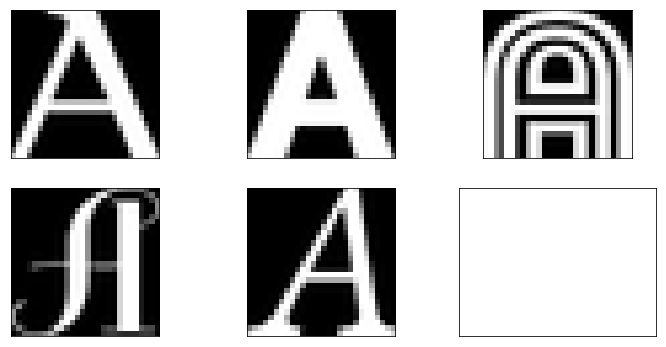

In [55]:

def _usage_show_images():    
    some_images = my_train_a[0:5,:,:]
#     display('5 images:')
#     show_some_images(some_images)
#     display('2 images - in normal array')
#     show_some_images([some_images[0,:,:], some_images[1,:,:]])
    
    show_some_images(some_images, small=True)
    

_usage_show_images()

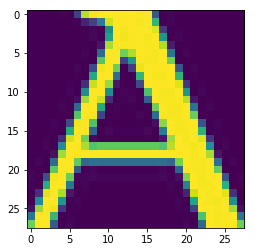

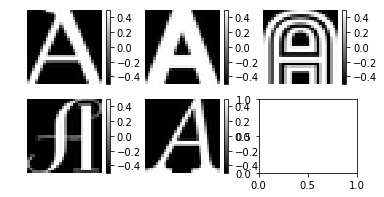

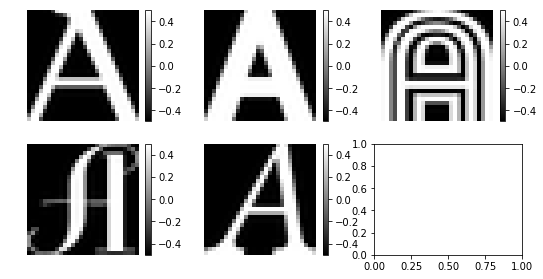

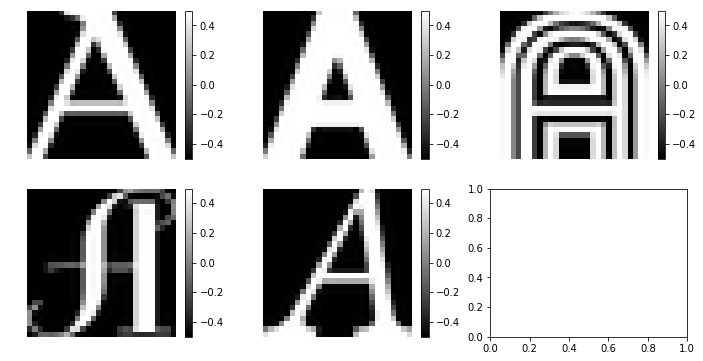

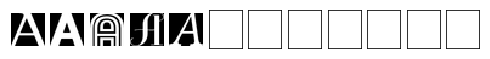

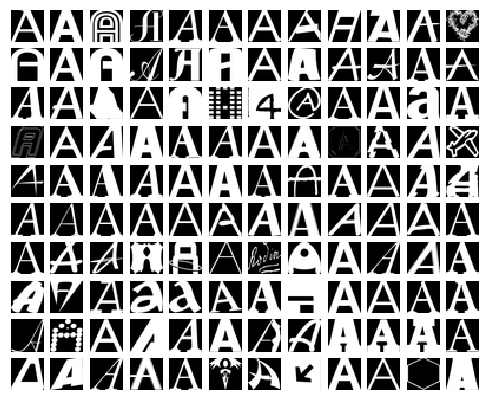

72.0

In [105]:

def small_show(list_images, do_colorbar=True, cmap='gray', scale=1.0, small=False):    
    num_images = len(list_images)
    num_cols = 3
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)
    
    subplot_kw = None if not small else {'xticks': [], 'yticks': []}
    
    if small:
        fig_1 = plt.figure()
        pix_in = (28.0 / fig_1.dpi) * 1.8
#         figsize = (scale*4*num_cols, scale*3*num_rows)
        num_cols = 12
        num_rows = num_images // num_cols + int(num_images % num_cols > 0)
        figsize = (scale*pix_in*num_cols, scale*pix_in*num_rows)
    else:
        figsize = (scale*4*num_cols, scale*3*num_rows)
#     fig, axes = plt.subplots(figsize=figsize, ncols=num_cols, nrows=num_rows,
#                              subplot_kw=subplot_kw)
    fig, axes = plt.subplots(
        figsize=figsize,
        ncols=num_cols,
        nrows=num_rows,
        subplot_kw=subplot_kw
    )
    
    # fig, axes = plt.subplots(1,3)
    for i,img in enumerate(list_images):
        r = i // num_cols
        c = i % num_cols
        target_axis = axes[r, c] if num_rows > 1 else axes[i]
        h_img = target_axis.imshow(img, clim=(-0.5, 0.5), cmap=cmap)
#         target_axis.axis('off')
        if do_colorbar and not small: fig.colorbar(h_img, ax=target_axis)
    
    plt.show()

some_images = my_train_a[0:5,:,:]

# plt.figure()
fig, ax = plt.subplots()
# ax.imshow(some_images[0], origin='upper', extent=(0,25,0,25))
ax.imshow(some_images[0],
#           origin='upper', extent=(0,25,0,25)
         )
# plt.box(False)
# plt.tight_layout()
# ax.autoscale(tight=True)
# ax.set_aspect('equal')
# ax.axis('off')
plt.show()

small_show(some_images, scale=0.5)
small_show(some_images, scale=0.75)
small_show(some_images, scale=1.0)

small_show(some_images, small=True)
small_show(my_train_a[0:120], small=True)
# width_in = 
# pix_width = (pixels / inch) * inches
# 28 = (dpi) * inches
display(fig.dpi)

# f = plt.figure()
# nx = int(f.get_figwidth() * f.dpi)
# ny = int(f.get_figheight() * f.dpi)
# # data = np.random.random((ny, nx))
# f.figimage(some_images[2], resize=True)
# plt.show()


In [21]:
# (old) Show an image *file* (eg: png)
def image_file_display(filename = None):
    ### NOTE: '\=' in the system ls translates to just '=' here, in this (auto-escaped?) filename string
    example_file = "/notebooks/notMNIST_small/A/QnVsbWVyLUl0bC5vdGY=.png"
    show_filename = filename if filename is not None else example_file

    an_image_file = Image(filename=show_filename)
    display(an_image_file)


# Data Statistics / Analysis

In [17]:
# Check data sets are "balanced" -
#   roughly similar number of samples/class
#   and roughly similar descriptave statistics of data
#   (pretty basic - avg pixel lightness) i.e. mean + std_dev 

# names of pickled files
# letter_datasets_files

def get_data_stats(letter=None):
    letter_class = coerce_letter2char(letter)
    cls_data = load_letter_pickle(letter)
#     cls_data = load_letter_pickle(letter_class, verbose=False)
    return calc_data_stats(cls_data, letter_class)

def calc_data_stats(cls_data, letter_class = None):
    cstats = dict()
    cstats['label'] = letter_class if letter_class is not None else ''
    cstats['n_samples'] = cls_data.shape[0]
    cstats['mean'] = cls_data.mean()   # hopefully, around 0
    cstats['stddev'] = cls_data.std()  # hopefully, similar to other samples/sets
    return cstats

def _usage_data_stats():
    display(letter_datasets_files)
    data_stats = [get_data_stats(datafile) for datafile in letter_datasets_files]
    d_data_stats = {d.pop('label'): d for d in data_stats}

    # display(get_data_stats('a'))
    display(d_data_stats)
    
# _usage_data_stats()

---


- - -



---
# [ ================        SCRAP        ================ ]

# Semi-Scrap -- Errr... other sorta fns?


Not as useful stuff / more... examples stuff here


## "Cleaning" up datasets

In [31]:
from hashlib import md5

### Clean: Remove exact duplicates [hash]

In [32]:
def _exec_uniquify_by_hash(
            train_dataset, valid_dataset, test_dataset
        ):
    # Eliminate duplicate images in+across train, valid, and test datasets
    one_set = np.concatenate((train_dataset, valid_dataset, test_dataset))
    h_some = np.array([md5(e_i).digest() for idx, e_i in enumerate(one_set)])
    h_uniq, idxes = np.unique(h_some, return_index=True)

    len_train_valid = (train_dataset.shape[0] + valid_dataset.shape[0])
    uidx_train = idxes[idxes < train_dataset.shape[0]]
    uidx_valid = idxes[(idxes >= train_dataset.shape[0]) & (idxes < len_train_valid)] - train_dataset.shape[0]
    uidx_test = idxes[idxes >= len_train_valid] - len_train_valid

    # Output:
    train_dataset_unq = train_dataset[uidx_train]
    train_labels_unq = train_labels[uidx_train]
    valid_dataset_unq = valid_dataset[uidx_valid]
    valid_labels_unq = valid_labels[uidx_valid]
    test_dataset_unq  = test_dataset[uidx_test]
    test_labels_unq  = test_labels[uidx_test]

    
    # Compare results
    # original sizes
    display(train_dataset.shape)
    display(valid_dataset.shape)
    display(test_dataset.shape)
    # new sizes
    display(train_dataset_unq.shape)
    display(valid_dataset_unq.shape)
    display(test_dataset_unq.shape)

### Clean: Min Variance threshold
Remove (almost) completely white & (almost) completely black images


In [26]:
# Choose variance threshold:
# - This var is pretty much just all white images
# t_var_min = bins3[1]
t_var_min = 2.41832e-05
# - This var includes a bit more than just the pure nothing
# t_var_min = bins2[1]
t_var_min = 0.000242272

# t_var_min = 0.000242272

# Remove "not useful"(?) images below some variance threshold
def usefulify(one_set, var_threshold = t_var_min, return_index = False):
    display(one_set.shape)
    d_var_idxes = (np.var(one_set, axis=(1,2)) >= var_threshold)
    better_set = one_set[d_var_idxes]
    display(better_set.shape)
    if return_index:
        return better_set, d_var_idxes
    return better_set


In [29]:
### Usage of usefulify:
def _exec_usage_usefulify(train_dataset, train_dataset_unq):
    usefulify(train_dataset)
    tu_min = usefulify(train_dataset_unq)
    show_some_images(tu_min[24000:24024])


### Here we will actually create min variance

In [30]:
# Eliminate low-variance images in train, valid, and test datasets
# t_var_min = 0.000242272

def _exec_usefulify_stuff(
            train_dataset_unq, train_labels_unq,
            valid_dataset_unq, valid_labels_unq,
            test_dataset_unq, test_labels_unq
        ):
    train_dataset_min, vidx_train = usefulify(train_dataset_unq, return_index=True)
    train_labels_min = train_labels_unq[vidx_train]
    valid_dataset_min, vidx_valid = usefulify(valid_dataset_unq, return_index=True)
    valid_labels_min = valid_labels_unq[vidx_valid]
    test_dataset_min, vidx_test = usefulify(test_dataset_unq, return_index=True)
    test_labels_min = test_labels_unq[vidx_test]
